In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
defunciones = pd.read_excel('/content/drive/My Drive/CIENCIA DE DATOS-Colab Notebooks/DATASETS DEFUNCIONES/defunciones_procesado.xlsx')
defunciones.head(10)

,año,jurisdiccion_de_residencia_id,jurisdiccion_de_residencia_nombre,sexo_id,sexo_nombre,cie10_causa_id,cie10_causa_nombre,grupos_edad_id,grupos_edad_nombre,cantidad_de_defunciones,poblacion,cantidad_de_defunciones_percapita,letra_causa,numero_causa,causa_muerte
0,2010,2,Ciudad Aut. de Buenos Aires,2,Mujer,J98,Otros trastornos respiratorios,7,30 a 34,2,1622915,1.232350e-06,J,98,Enfermedades del sistema respiratorio
1,2010,14,Córdoba,2,Mujer,G60,Neuropatía hereditaria e idiopática,4,15 a 19,1,1730725,5.777925e-07,G,60,Enfermedades del sistema nervioso
2,2010,6,Buenos Aires,1,Varón,I38,"Endocarditis, válvula no especificada",17,80 y más,1,10496134,9.527317e-08,I,38,Enfermedades del sistema circulatorio
3,2010,30,Entre Ríos,2,Mujer,G12,Atrofia muscular espinal y síndromes afines,14,65 a 69,1,640467,1.561361e-06,G,12,Enfermedades del sistema nervioso
4,2010,14,Córdoba,1,Varón,Y20,"Ahorcamiento, estrangulamiento y sofocación, d...",16,75 a 79,1,1642300,6.089021e-07,Y,20,Eventos de intención no determinada
5,2010,30,Entre Ríos,1,Varón,J20,Bronquitis aguda,2,1 a 9,1,615107,1.625733e-06,J,20,Enfermedades del sistema respiratorio
6,2010,6,Buenos Aires,2,Mujer,G61,Polineuopatía inflamatoria,10,45 a 49,1,10966864,9.118377e-08,G,61,Enfermedades del sistema nervioso
7,2010,74,San Luis,1,Varón,X74,Lesión autoinfligida intencionalmente por disp...,12,55 a 59,2,219940,9.093389e-06,X,74,Lesiones autoinflingidas intencionalmente
8,2010,90,Tucumán,1,Varón,C25,Tumor maligno del páncreas,17,80 y más,3,733744,4.088619e-06,C,25,Tumores (neoplasias) malignos
9,2010,38,Jujuy,1,Varón,X31,Exposición al frío natural excesivo,15,70 a 74,1,336954,2.967764e-06,X,31,Exposición a fuerzas de la naturaleza


# **Intentaremos predecir la cantidad de muertes a partir de los datos de año, grupos de edad y causa de muerte**

In [0]:
defunciones_g = defunciones.groupby(['grupos_edad_nombre','año','causa_muerte'])["cantidad_de_defunciones"].sum().to_frame().reset_index()
defunciones_g.head()

,grupos_edad_nombre,año,causa_muerte,cantidad_de_defunciones
0,1 a 9,2010,Accidentes de transporte,161
1,1 a 9,2010,Agresiones,28
2,1 a 9,2010,Ciertas enfermedades infecciosas y parasitarias,134
3,1 a 9,2010,Complicaciones de la atención médica y quirúrgica,6
4,1 a 9,2010,Contacto traumático con animales y plantas ven...,3


In [0]:
defunciones_g.describe()

,año,cantidad_de_defunciones
count,3742.000000,3742.000000
mean,2013.525387,698.565473
std,2.295882,3029.776299
min,2010.000000,1.000000
25%,2012.000000,18.000000
50%,2014.000000,92.000000
75%,2016.000000,251.000000
max,2017.000000,50291.000000




---

# **Aplicaremos modelos de regresion para predecir la cantidad de defunciones**

In [0]:
df_train = pd.DataFrame(defunciones_g)



---

# **Generamos dummies de las causas de muerte**

In [0]:
causa_muerte_dummies = pd.get_dummies(df_train.causa_muerte)
df_train = pd.concat([df_train,causa_muerte_dummies], axis=1)
df_train.shape

grupos_edad_dummies = pd.get_dummies(df_train.grupos_edad_nombre)
df_train = pd.concat([df_train,grupos_edad_dummies], axis=1)
df_train.shape

(3742, 55)

In [0]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import accuracy_score
y = np.array(df_train[["cantidad_de_defunciones"]])
x = df_train.drop(['causa_muerte', 'cantidad_de_defunciones','grupos_edad_nombre'], axis=1)
#x = df_train.drop(['cantidad_de_defunciones','cie10_causa_nombre'], axis=1)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.01, random_state=54)

In [0]:
xtrain.shape

(3704, 52)

In [0]:
xtrain.head()

,año,Accidentes de transporte,Agresiones,Ciertas afecciones originadas en el periodo neonatal,Ciertas enfermedades infecciosas y parasitarias,Complicaciones de la atención médica y quirúrgica,Contacto traumático con animales y plantas venesosas,"Embarazo, parto y puerperio",Enfermedades de la piel y el tejido subcutáneo,Enfermedades de la sangre y de los órganos hematopoyéticos y ciertos trastornos que afectan el mecanismo de la inmunidad,Enfermedades del ojo y sus anexos,Enfermedades del oído y de la apófisis mastoides,Enfermedades del sistema circulatorio,Enfermedades del sistema digestivo,Enfermedades del sistema genitourinario,Enfermedades del sistema nervioso,Enfermedades del sistema osteomuscular y del tejido conjuntivo,Enfermedades del sistema respiratorio,"Enfermedades endócrinas, nutricionales y metabólicas",Envenenamiento accidental por exposición a sustancias nocivas,Eventos de intención no determinada,"Exceso de esfuerzo, viajes y privación",Exposición a fuerzas de la naturaleza,Exposición accidental a otros factores y a los no especificados,"Exposición al fuego, humo y llamas",Infecciones virales caracterizadas por lesiones de la piel y de la membranas mucosas,Intervención legal y operaciones de guerra,Lesiones autoinflingidas intencionalmente,Malformaciones congénitas,Otras causas externas de traumatismos accidentales,Secuelas de causas externas de morbilidad y mortalidad,"Sintomas, signos y hallazgos anormales clinicos y de laboratorio no clasificados en otra parte",Trastornos mentales y del comportamiento,Tumores (neoplasias),Tumores (neoplasias) malignos,1 a 9,10 a 14,15 a 19,20 a 24,25 a 29,30 a 34,35 a 39,40 a 44,45 a 49,50 a 54,55 a 59,60 a 64,65 a 69,70 a 74,75 a 79,80 y más,Menor de 1 año
2606,2016,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3495,2016,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2914,2011,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1738,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2562,2014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [0]:
# auto scaling train- set (mean = 0, std = 1)
scaler = preprocessing.StandardScaler().fit(xtrain)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
# auto scalo mis muestras de train utilizando el scaler fiteado con el xtrain
xtrain_scal = scaler.transform(xtrain)

In [0]:
# auto scalo mis muestras de test utilizando el scaler fiteado con el xtrain
xtest_scal = scaler.transform(xtest)

# **Realizamos un PCA con el set de entrenamiento**


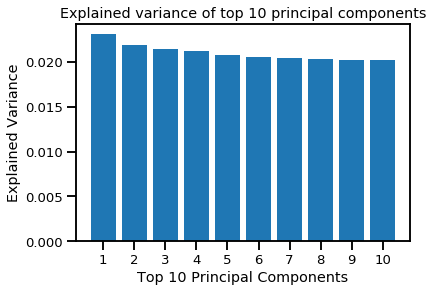

In [0]:
from sklearn.decomposition import PCA
# cantidad de componentes a extraer
n_comps = 10
# definimos PCA
pca = PCA(n_components= n_comps)
# fit_transform del PCA a nuestros datos
xpca = pd.DataFrame(pca.fit_transform(xtrain_scal))
# obtenemos los auto-valores
eigenvalues = pca.explained_variance_ratio_

components = range(1,n_comps + 1)
plt.bar(components,eigenvalues)
plt.xticks(components)
plt.title('Explained variance of top 10 principal components')
plt.xlabel('Top 10 Principal Components')
plt.ylabel('Explained Variance')
plt.show()

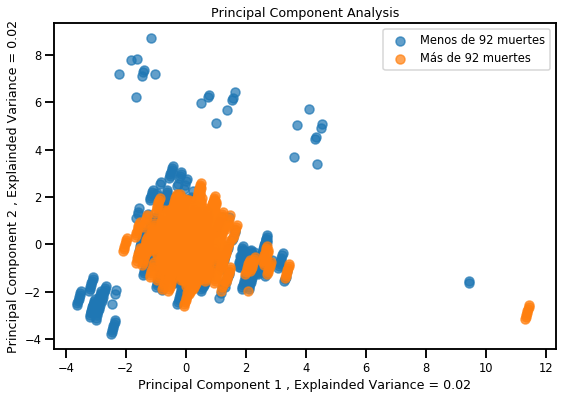

In [0]:
sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(9,6))
quantil = df_train.cantidad_de_defunciones.quantile(0.50)
plt.scatter(xpca.loc[(ytrain < quantil).ravel(),0],xpca.loc[(ytrain < quantil).ravel(),1], alpha = 0.7, label = 'Menos de ' + str(int(np.round(quantil))) + ' muertes')
plt.scatter(xpca.loc[(ytrain > quantil).ravel(),0],xpca.loc[(ytrain > quantil).ravel(),1], alpha = 0.7, label = 'Más de ' + str(int(np.round(quantil))) + ' muertes')
plt.xlabel('Principal Component 1 , Explainded Variance = ' + str(np.round(eigenvalues[0],2)))
plt.ylabel('Principal Component 2 , Explainded Variance = ' + str(np.round(eigenvalues[1],2)))
plt.title('Principal Component Analysis')
plt.legend(loc='upper right')
plt.show()

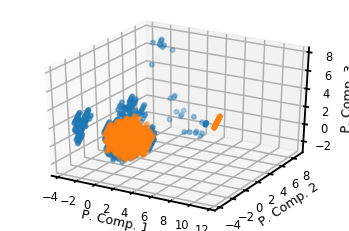

In [0]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xpca.iloc[(ytrain < quantil).ravel(),0], xpca.iloc[(ytrain < quantil).ravel(),1], xpca.iloc[(ytrain < quantil).ravel(),2])
ax.scatter(xpca.iloc[(ytrain > quantil).ravel(),0], xpca.iloc[(ytrain > quantil).ravel(),1], xpca.iloc[(ytrain > quantil).ravel(),2])
ax.set_xlabel('P. Comp. 1')
ax.set_ylabel('P. Comp. 2')
ax.set_zlabel('P. Comp. 3')
plt.show()



---


# **PROBAMOS UN SVR**




In [0]:
# creo un modelo de SVR
svreg = SVR()

In [0]:
# cantidad de folds para el cross validation
n_folds = 5

In [0]:
# Distintos hiper parametros a probar en grid search (pruebo gridsearch por kernels separados)
#parameters_svr_lin = [{'kernel':['linear'], 'C': [1, 100]}]

#parameters_svr_rbf = [{'kernel':['rbf'] , 'C': [1,100],'gamma': [0.1,0.5] }]

parameters_svr = [{'kernel':('linear', 'rbf'),'C': [1,100],'gamma': [0.1,0.5] }]

#parameters_svr = {'kernel':('linear', 'rbf'), 'C':[1000], 'gamma':[100]}

In [0]:
regresor_svr = GridSearchCV(svreg, parameters_svr, cv=n_folds, refit=True, verbose=True)

In [0]:
# entreno modelo regresor con mi set de entrenamiento (tanto Xtrain como Ytrain)
regresor_svr.fit(xtrain_scal, ytrain.ravel())

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 100], 'gamma': [0.1, 0.5],
                          'kernel': ('linear', 'rbf')}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [0]:
# vemos cuales son los mejores parametros luego del cross validation
regresor_svr.best_params_

{'C': 100, 'gamma': 0.1, 'kernel': 'linear'}

In [0]:
regresor_svr.best_score_

0.06702647916885941

In [0]:
ypred3 = regresor_svr.predict(xtest_scal)
ypred3

array([  83.56608667, 1290.56696036,  -59.96278491,  716.23136608,
        322.8323178 ,   72.30078119,  223.63267165,  597.03694618,
         19.23241864,   46.83174742,  280.8333918 ,  231.16626531,
       1273.96640277,   80.70247919,   71.50387879,  385.49975703,
         47.0983982 ,  430.09816883,  448.36584079,  118.29734089,
        293.57180672,  515.49563424,  -30.09773392,  107.83302128,
          6.03304856,  448.63249156,   59.76459942,   95.03140191,
        122.29622335,  251.03331977,  158.36170796,   70.62990766,
         -3.90049827,  120.3653663 ,   38.50237286,   45.03446084,
         70.0333975 ,  162.10213677])

In [0]:
# computo RMSE (root mean squared error) -> cuando le doy importancia a grandes errores
np.sqrt(mean_squared_error(ytest, ypred3))

657.144569812733

In [0]:
# computo MAE (mean absolute error)
mean_absolute_error(ytest, ypred3)

282.65057388934974

In [0]:
print(regresor_svr.score(xtest_scal,ytest.ravel())) #obtenemos el promedio de la accuracy

0.22535230158512842


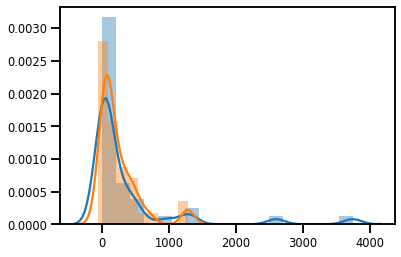

In [0]:
# visualiza el rango de valores de las etiquetas de test y las predecidas
sns.distplot(ytest)
sns.distplot(ypred3)
plt.show()



---
# **Probamos un modelo de Regresion Lineal**


In [0]:
# 1) creo un modelo generico de regresion lineal
lr = LinearRegression()

In [0]:
# 2) Ajusto el modelo de regresion lineal utilizando el set de train, tanto las features X como las samples Y
lr.fit(xtrain_scal, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# 3) Obtengo las predicciones que realiza mi modelo con las muestras de test, sin mostrarle las labels (Ytest)
# las predicciones las guardo en el vector "ypred"
ypred = lr.predict(xtest_scal)

In [0]:
np.shape(ypred)

(38, 1)

In [0]:
ypred

array([[-4.01767651e+02],
       [ 3.11023235e+03],
       [-1.06376765e+03],
       [ 4.91623235e+03],
       [ 1.15823235e+03],
       [-5.87767651e+02],
       [ 1.62323488e+01],
       [ 3.00823235e+03],
       [-4.37767651e+02],
       [ 2.84232349e+02],
       [ 3.01623235e+03],
       [ 8.02323488e+01],
       [ 3.00123235e+03],
       [-4.61767651e+02],
       [-4.23767651e+02],
       [ 7.94232349e+02],
       [ 2.88232349e+02],
       [ 9.90232349e+02],
       [ 1.07423235e+03],
       [-3.76767651e+02],
       [ 3.52423235e+03],
       [ 2.03823235e+03],
       [-6.57767651e+02],
       [ 6.18232349e+02],
       [-5.17767651e+02],
       [ 1.08223235e+03],
       [ 1.08232349e+02],
       [ 5.94232349e+02],
       [-3.85767651e+02],
       [ 1.06023235e+03],
       [ 7.14232349e+02],
       [ 6.90232349e+02],
       [-4.14767651e+02],
       [ 1.10232349e+02],
       [-2.31767651e+02],
       [-2.99767651e+02],
       [-2.08015116e+00],
       [ 7.26419849e+02]])

In [0]:
# calculo el error de mi modelo con las muestras de train = error de train
np.sqrt(mean_squared_error(ytest, ypred))

1122.6867488056002

In [0]:
mean_squared_error(ytest, ypred)

1260425.5359436888

In [0]:
mean_absolute_error(ytest, ypred)

786.4727552018479

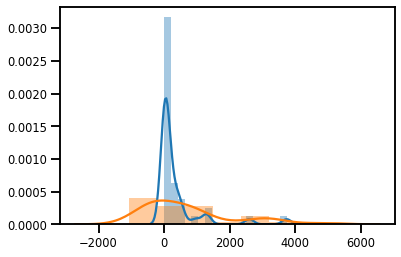

In [0]:
# visualiza el rango de valores de las etiquetas de test y las predecidas
sns.distplot(ytest)
sns.distplot(ypred)
plt.show()

# **Probamos un modelo KNN**

In [0]:
neigh = KNeighborsRegressor(weights = "distance")
#parameters_k = np.arange(20,31,5)
parameters_k = np.arange(2,11,1)
parameters_knn = [{'n_neighbors': parameters_k}]
# indico la cantidad de folds que quiero utilizar en mi training para cross validation
n_folds = 5
# creo un modelo que contiene, el regresor a utilizar, la grilla de parametros a probar
# y la cantidad de folds para el cross validation
regresor_neigh = GridSearchCV(neigh, parameters_knn, refit = True, cv=n_folds, verbose=True)
# entreno modelo regresor con mi set de entrenamiento (tanto Xtrain como Ytrain)
regresor_neigh.fit(xtrain_scal, ytrain)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    8.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='distance'),
             iid='warn', n_jobs=None,
             param_grid=[{'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [0]:
# observo cual fue el parametro que "gano" en el cross validation y grid search
regresor_neigh.best_params_

{'n_neighbors': 2}

In [0]:
# calcula el R2
regresor_neigh.best_score_

0.9965142692505409

In [0]:
# realizo con mi modelo entrenado, predicciones de Y (ypred) utilizando solo xtest
ypred2 = regresor_neigh.predict(xtest_scal)
#ypred2.astype(int)

In [0]:
# computo la raiz cuadrada del error cuadratico medio entre ytest (etiqueta real) vs ypred (etiqueta estimada por el modelo)
np.sqrt(mean_squared_error(ytest, ypred2))

37.22908799266531

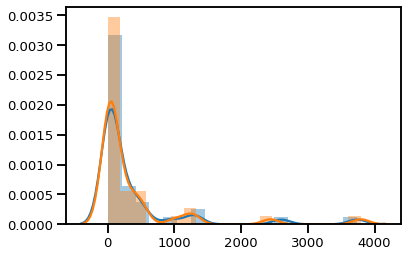

In [0]:
# visualiza el rango de valores de las etiquetas de test y las predecidas
sns.distplot(ytest)
sns.distplot(ypred2)
#sns.distplot(np.log(1+ytest))
#sns.distplot(np.log(1+ypred2))   
plt.show()

In [0]:
xtrain.head()

,año,Accidentes de transporte,Agresiones,Ciertas afecciones originadas en el periodo neonatal,Ciertas enfermedades infecciosas y parasitarias,Complicaciones de la atención médica y quirúrgica,Contacto traumático con animales y plantas venesosas,"Embarazo, parto y puerperio",Enfermedades de la piel y el tejido subcutáneo,Enfermedades de la sangre y de los órganos hematopoyéticos y ciertos trastornos que afectan el mecanismo de la inmunidad,Enfermedades del ojo y sus anexos,Enfermedades del oído y de la apófisis mastoides,Enfermedades del sistema circulatorio,Enfermedades del sistema digestivo,Enfermedades del sistema genitourinario,Enfermedades del sistema nervioso,Enfermedades del sistema osteomuscular y del tejido conjuntivo,Enfermedades del sistema respiratorio,"Enfermedades endócrinas, nutricionales y metabólicas",Envenenamiento accidental por exposición a sustancias nocivas,Eventos de intención no determinada,"Exceso de esfuerzo, viajes y privación",Exposición a fuerzas de la naturaleza,Exposición accidental a otros factores y a los no especificados,"Exposición al fuego, humo y llamas",Infecciones virales caracterizadas por lesiones de la piel y de la membranas mucosas,Intervención legal y operaciones de guerra,Lesiones autoinflingidas intencionalmente,Malformaciones congénitas,Otras causas externas de traumatismos accidentales,Secuelas de causas externas de morbilidad y mortalidad,"Sintomas, signos y hallazgos anormales clinicos y de laboratorio no clasificados en otra parte",Trastornos mentales y del comportamiento,Tumores (neoplasias),Tumores (neoplasias) malignos,1 a 9,10 a 14,15 a 19,20 a 24,25 a 29,30 a 34,35 a 39,40 a 44,45 a 49,50 a 54,55 a 59,60 a 64,65 a 69,70 a 74,75 a 79,80 y más,Menor de 1 año
2606,2016,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3495,2016,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2914,2011,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1738,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2562,2014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


# **Intentaremos precedir, dado el rango de edad y causa de muerte, la cantidad de defunciones para los años 2018, 2019 y 2020.**
Recordar que solo contamos con datos hasta 2017

In [0]:
xtestfuturo_modelo = pd.DataFrame(df_train)
xtestfuturo_modelo.head()
xtestfuturo_modelo = xtestfuturo_modelo.loc[(xtestfuturo_modelo.año == 2017)]
xtestfuturo_modelo = xtestfuturo_modelo.drop(['causa_muerte', 'cantidad_de_defunciones','grupos_edad_nombre'], axis=1)
xtestfuturo_modelo.head()

,año,Accidentes de transporte,Agresiones,Ciertas afecciones originadas en el periodo neonatal,Ciertas enfermedades infecciosas y parasitarias,Complicaciones de la atención médica y quirúrgica,Contacto traumático con animales y plantas venesosas,"Embarazo, parto y puerperio",Enfermedades de la piel y el tejido subcutáneo,Enfermedades de la sangre y de los órganos hematopoyéticos y ciertos trastornos que afectan el mecanismo de la inmunidad,Enfermedades del ojo y sus anexos,Enfermedades del oído y de la apófisis mastoides,Enfermedades del sistema circulatorio,Enfermedades del sistema digestivo,Enfermedades del sistema genitourinario,Enfermedades del sistema nervioso,Enfermedades del sistema osteomuscular y del tejido conjuntivo,Enfermedades del sistema respiratorio,"Enfermedades endócrinas, nutricionales y metabólicas",Envenenamiento accidental por exposición a sustancias nocivas,Eventos de intención no determinada,"Exceso de esfuerzo, viajes y privación",Exposición a fuerzas de la naturaleza,Exposición accidental a otros factores y a los no especificados,"Exposición al fuego, humo y llamas",Infecciones virales caracterizadas por lesiones de la piel y de la membranas mucosas,Intervención legal y operaciones de guerra,Lesiones autoinflingidas intencionalmente,Malformaciones congénitas,Otras causas externas de traumatismos accidentales,Secuelas de causas externas de morbilidad y mortalidad,"Sintomas, signos y hallazgos anormales clinicos y de laboratorio no clasificados en otra parte",Trastornos mentales y del comportamiento,Tumores (neoplasias),Tumores (neoplasias) malignos,1 a 9,10 a 14,15 a 19,20 a 24,25 a 29,30 a 34,35 a 39,40 a 44,45 a 49,50 a 54,55 a 59,60 a 64,65 a 69,70 a 74,75 a 79,80 y más,Menor de 1 año
180,2017,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
181,2017,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
182,2017,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
183,2017,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
184,2017,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
xtestfuturo_modelo.shape

(481, 52)

A partir del dataset 2017, genero 3 copias para 2018, 2019 y 2020 y las concateno

In [0]:
xtestfuturo2018 = xtestfuturo_modelo.copy()
xtestfuturo2018['año'] = 2018
xtestfuturo2019 = xtestfuturo_modelo.copy()
xtestfuturo2019['año'] = 2019
xtestfuturo2020 = xtestfuturo_modelo.copy()
xtestfuturo2020['año'] = 2020

xtestfuturo = pd.concat([xtestfuturo2018,xtestfuturo2019,xtestfuturo2020], axis=0, sort=False, ignore_index=True)
xtestfuturo.shape

(1443, 52)

In [0]:
scaler_f = preprocessing.StandardScaler().fit(xtrain)
scaler_f
xtestfuturo_scal = scaler_f.transform(xtestfuturo)

In [0]:
xtestfuturo_scal

array([[ 1.95089465,  5.12204003, -0.19448836, ..., -0.25250042,
        -0.25370813, -0.23445702],
       [ 1.95089465, -0.19523471,  5.14169593, ..., -0.25250042,
        -0.25370813, -0.23445702],
       [ 1.95089465, -0.19523471, -0.19448836, ..., -0.25250042,
        -0.25370813, -0.23445702],
       ...,
       [ 2.82324496, -0.19523471, -0.19448836, ..., -0.25250042,
        -0.25370813,  4.26517407],
       [ 2.82324496, -0.19523471, -0.19448836, ..., -0.25250042,
        -0.25370813,  4.26517407],
       [ 2.82324496, -0.19523471, -0.19448836, ..., -0.25250042,
        -0.25370813,  4.26517407]])

In [0]:
# realizo con mi modelo entrenado, predicciones de Y 2018 2019 2010 (ypred) utilizando solo xtestfuturo
ypred181920 = regresor_neigh.predict(xtestfuturo_scal)
#ypred2018.astype(int)

In [0]:
futuro181920 = pd.DataFrame(xtestfuturo)
futuro181920['cantidad_de_defunciones'] = 0
for r in range(0,futuro181920.shape[0]):
  futuro181920['cantidad_de_defunciones'].values[r] = ypred181920[r]
futuro181920.head()

,año,Accidentes de transporte,Agresiones,Ciertas afecciones originadas en el periodo neonatal,Ciertas enfermedades infecciosas y parasitarias,Complicaciones de la atención médica y quirúrgica,Contacto traumático con animales y plantas venesosas,"Embarazo, parto y puerperio",Enfermedades de la piel y el tejido subcutáneo,Enfermedades de la sangre y de los órganos hematopoyéticos y ciertos trastornos que afectan el mecanismo de la inmunidad,Enfermedades del ojo y sus anexos,Enfermedades del oído y de la apófisis mastoides,Enfermedades del sistema circulatorio,Enfermedades del sistema digestivo,Enfermedades del sistema genitourinario,Enfermedades del sistema nervioso,Enfermedades del sistema osteomuscular y del tejido conjuntivo,Enfermedades del sistema respiratorio,"Enfermedades endócrinas, nutricionales y metabólicas",Envenenamiento accidental por exposición a sustancias nocivas,Eventos de intención no determinada,"Exceso de esfuerzo, viajes y privación",Exposición a fuerzas de la naturaleza,Exposición accidental a otros factores y a los no especificados,"Exposición al fuego, humo y llamas",Infecciones virales caracterizadas por lesiones de la piel y de la membranas mucosas,Intervención legal y operaciones de guerra,Lesiones autoinflingidas intencionalmente,Malformaciones congénitas,Otras causas externas de traumatismos accidentales,Secuelas de causas externas de morbilidad y mortalidad,"Sintomas, signos y hallazgos anormales clinicos y de laboratorio no clasificados en otra parte",Trastornos mentales y del comportamiento,Tumores (neoplasias),Tumores (neoplasias) malignos,1 a 9,10 a 14,15 a 19,20 a 24,25 a 29,30 a 34,35 a 39,40 a 44,45 a 49,50 a 54,55 a 59,60 a 64,65 a 69,70 a 74,75 a 79,80 y más,Menor de 1 año,cantidad_de_defunciones
0,2018,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,134
1,2018,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27
2,2018,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
3,2018,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,88
4,2018,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7


In [0]:
defunciones_before = df_train.drop(['causa_muerte','grupos_edad_nombre'], axis=1)
defunciones_complete = pd.concat([defunciones_before,futuro181920], axis=0, sort=False)

In [0]:
defunciones_complete.head()

,año,cantidad_de_defunciones,Accidentes de transporte,Agresiones,Ciertas afecciones originadas en el periodo neonatal,Ciertas enfermedades infecciosas y parasitarias,Complicaciones de la atención médica y quirúrgica,Contacto traumático con animales y plantas venesosas,"Embarazo, parto y puerperio",Enfermedades de la piel y el tejido subcutáneo,Enfermedades de la sangre y de los órganos hematopoyéticos y ciertos trastornos que afectan el mecanismo de la inmunidad,Enfermedades del ojo y sus anexos,Enfermedades del oído y de la apófisis mastoides,Enfermedades del sistema circulatorio,Enfermedades del sistema digestivo,Enfermedades del sistema genitourinario,Enfermedades del sistema nervioso,Enfermedades del sistema osteomuscular y del tejido conjuntivo,Enfermedades del sistema respiratorio,"Enfermedades endócrinas, nutricionales y metabólicas",Envenenamiento accidental por exposición a sustancias nocivas,Eventos de intención no determinada,"Exceso de esfuerzo, viajes y privación",Exposición a fuerzas de la naturaleza,Exposición accidental a otros factores y a los no especificados,"Exposición al fuego, humo y llamas",Infecciones virales caracterizadas por lesiones de la piel y de la membranas mucosas,Intervención legal y operaciones de guerra,Lesiones autoinflingidas intencionalmente,Malformaciones congénitas,Otras causas externas de traumatismos accidentales,Secuelas de causas externas de morbilidad y mortalidad,"Sintomas, signos y hallazgos anormales clinicos y de laboratorio no clasificados en otra parte",Trastornos mentales y del comportamiento,Tumores (neoplasias),Tumores (neoplasias) malignos,1 a 9,10 a 14,15 a 19,20 a 24,25 a 29,30 a 34,35 a 39,40 a 44,45 a 49,50 a 54,55 a 59,60 a 64,65 a 69,70 a 74,75 a 79,80 y más,Menor de 1 año
0,2010,161,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2010,28,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2010,134,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2010,6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2010,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
defunciones_complete.shape

(5185, 53)

In [0]:
defunciones_complete_dummies = defunciones_complete.drop(['año', 'cantidad_de_defunciones'], axis=1)

In [0]:
dummies_def = pd.Series(defunciones_complete_dummies.columns[np.where(defunciones_complete_dummies!=0)[1]])
dummies_def.shape[0]

10370

In [0]:
# ponemos las dummies como estaban originalmente
defunciones_complete['causa_muerte'] = ""
defunciones_complete['grupos_edad_nombre'] = ""
for r in range(1,defunciones_complete.shape[0]+1,1):
  defunciones_complete['causa_muerte'].values[r-1] = dummies_def[2*r-2]
  defunciones_complete['grupos_edad_nombre'].values[r-1] = dummies_def[2*r-1]
defunciones_complete.head()


,año,cantidad_de_defunciones,Accidentes de transporte,Agresiones,Ciertas afecciones originadas en el periodo neonatal,Ciertas enfermedades infecciosas y parasitarias,Complicaciones de la atención médica y quirúrgica,Contacto traumático con animales y plantas venesosas,"Embarazo, parto y puerperio",Enfermedades de la piel y el tejido subcutáneo,Enfermedades de la sangre y de los órganos hematopoyéticos y ciertos trastornos que afectan el mecanismo de la inmunidad,Enfermedades del ojo y sus anexos,Enfermedades del oído y de la apófisis mastoides,Enfermedades del sistema circulatorio,Enfermedades del sistema digestivo,Enfermedades del sistema genitourinario,Enfermedades del sistema nervioso,Enfermedades del sistema osteomuscular y del tejido conjuntivo,Enfermedades del sistema respiratorio,"Enfermedades endócrinas, nutricionales y metabólicas",Envenenamiento accidental por exposición a sustancias nocivas,Eventos de intención no determinada,"Exceso de esfuerzo, viajes y privación",Exposición a fuerzas de la naturaleza,Exposición accidental a otros factores y a los no especificados,"Exposición al fuego, humo y llamas",Infecciones virales caracterizadas por lesiones de la piel y de la membranas mucosas,Intervención legal y operaciones de guerra,Lesiones autoinflingidas intencionalmente,Malformaciones congénitas,Otras causas externas de traumatismos accidentales,Secuelas de causas externas de morbilidad y mortalidad,"Sintomas, signos y hallazgos anormales clinicos y de laboratorio no clasificados en otra parte",Trastornos mentales y del comportamiento,Tumores (neoplasias),Tumores (neoplasias) malignos,1 a 9,10 a 14,15 a 19,20 a 24,25 a 29,30 a 34,35 a 39,40 a 44,45 a 49,50 a 54,55 a 59,60 a 64,65 a 69,70 a 74,75 a 79,80 y más,Menor de 1 año,causa_muerte,grupos_edad_nombre
0,2010,161,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Accidentes de transporte,1 a 9
1,2010,28,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Agresiones,1 a 9
2,2010,134,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Ciertas enfermedades infecciosas y parasitarias,1 a 9
3,2010,6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Complicaciones de la atención médica y quirúrgica,1 a 9
4,2010,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Contacto traumático con animales y plantas ven...,1 a 9


In [0]:
#quitamos las dummies para tener nuestro dataset reconstruido
defunciones_complete = defunciones_complete.loc[:, ['grupos_edad_nombre','año','causa_muerte','cantidad_de_defunciones']] 
defunciones_complete.head(10)

,grupos_edad_nombre,año,causa_muerte,cantidad_de_defunciones
0,1 a 9,2010,Accidentes de transporte,161
1,1 a 9,2010,Agresiones,28
2,1 a 9,2010,Ciertas enfermedades infecciosas y parasitarias,134
3,1 a 9,2010,Complicaciones de la atención médica y quirúrgica,6
4,1 a 9,2010,Contacto traumático con animales y plantas ven...,3
5,1 a 9,2010,Enfermedades de la piel y el tejido subcutáneo,2
6,1 a 9,2010,Enfermedades de la sangre y de los órganos hem...,37
7,1 a 9,2010,Enfermedades del sistema circulatorio,73
8,1 a 9,2010,Enfermedades del sistema digestivo,43
9,1 a 9,2010,Enfermedades del sistema genitourinario,12


In [0]:
defunciones_complete.loc[(defunciones_complete.año == 2017)].head(5)

,grupos_edad_nombre,año,causa_muerte,cantidad_de_defunciones
180,1 a 9,2017,Accidentes de transporte,134
181,1 a 9,2017,Agresiones,28
182,1 a 9,2017,Ciertas afecciones originadas en el periodo ne...,4
183,1 a 9,2017,Ciertas enfermedades infecciosas y parasitarias,81
184,1 a 9,2017,Complicaciones de la atención médica y quirúrgica,8


In [0]:
defunciones_complete.loc[(defunciones_complete.año == 2018)].head(5)

,grupos_edad_nombre,año,causa_muerte,cantidad_de_defunciones
0,1 a 9,2018,Accidentes de transporte,134
1,1 a 9,2018,Agresiones,27
2,1 a 9,2018,Ciertas afecciones originadas en el periodo ne...,4
3,1 a 9,2018,Ciertas enfermedades infecciosas y parasitarias,88
4,1 a 9,2018,Complicaciones de la atención médica y quirúrgica,7


In [0]:
defunciones_complete.loc[(defunciones_complete.año == 2019)].head(5)

,grupos_edad_nombre,año,causa_muerte,cantidad_de_defunciones
481,1 a 9,2019,Accidentes de transporte,134
482,1 a 9,2019,Agresiones,26
483,1 a 9,2019,Ciertas afecciones originadas en el periodo ne...,4
484,1 a 9,2019,Ciertas enfermedades infecciosas y parasitarias,89
485,1 a 9,2019,Complicaciones de la atención médica y quirúrgica,6


In [0]:
defunciones_complete.loc[(defunciones_complete.año == 2020)].head(5)

,grupos_edad_nombre,año,causa_muerte,cantidad_de_defunciones
962,1 a 9,2020,Accidentes de transporte,134
963,1 a 9,2020,Agresiones,26
964,1 a 9,2020,Ciertas afecciones originadas en el periodo ne...,4
965,1 a 9,2020,Ciertas enfermedades infecciosas y parasitarias,90
966,1 a 9,2020,Complicaciones de la atención médica y quirúrgica,6


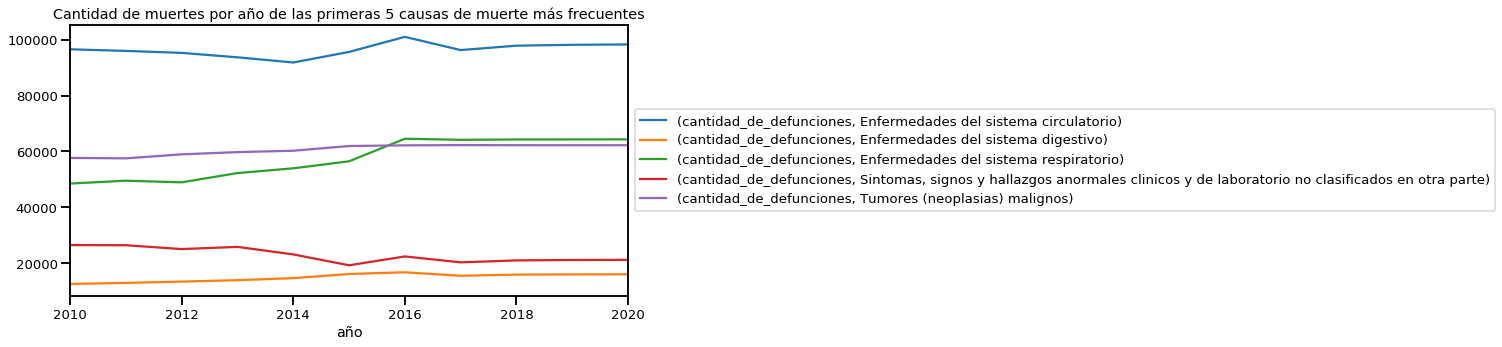

In [0]:
muertes_por_causa_año = defunciones_g.groupby(["causa_muerte"])["cantidad_de_defunciones"].sum().sort_values(ascending=False).iloc[0:10]
muertes_por_causa_año.to_frame()
df_muertes_por_causa_año = pd.DataFrame(muertes_por_causa_año)
df_muertes_por_causa_año['causa'] = df_muertes_por_causa_año.index
def2 = pd.DataFrame(defunciones_complete) 
def2 = def2.loc[(def2.causa_muerte == df_muertes_por_causa_año['causa'][0]) | (def2.causa_muerte == df_muertes_por_causa_año['causa'][1]) | (def2.causa_muerte == df_muertes_por_causa_año['causa'][2]) | (def2.causa_muerte == df_muertes_por_causa_año['causa'][3]) | (def2.causa_muerte == df_muertes_por_causa_año['causa'][4])]
flujo_tabla = pd.pivot_table(data = def2, values = ['cantidad_de_defunciones'], index = ['año'], columns = ['causa_muerte'], aggfunc= np.sum, )
sns.set_context("talk", font_scale=0.8)
flujo_tabla.plot(title = "Cantidad de muertes por año de las primeras 5 causas de muerte más frecuentes", figsize=(10,5))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [0]:
flujo_tabla

cantidad_de_defunciones  ...                              
causa_muerte Enfermedades del sistema circulatorio  ... Tumores (neoplasias) malignos
año                                                 ...                              
2010                                         96533  ...                         57691
2011                                         95956  ...                         57532
2012                                         95242  ...                         58968
2013                                         93666  ...                         59764
2014                                         91811  ...                         60252
2015                                         95591  ...                         61944
2016                                        100980  ...                         62181
2017                                         96256  ...                         62272
2018                                         97825  ...                         62237
2019                                         98138  ...                         62229
2020                                         98274  ...                         62225

[11 rows x 5 columns]

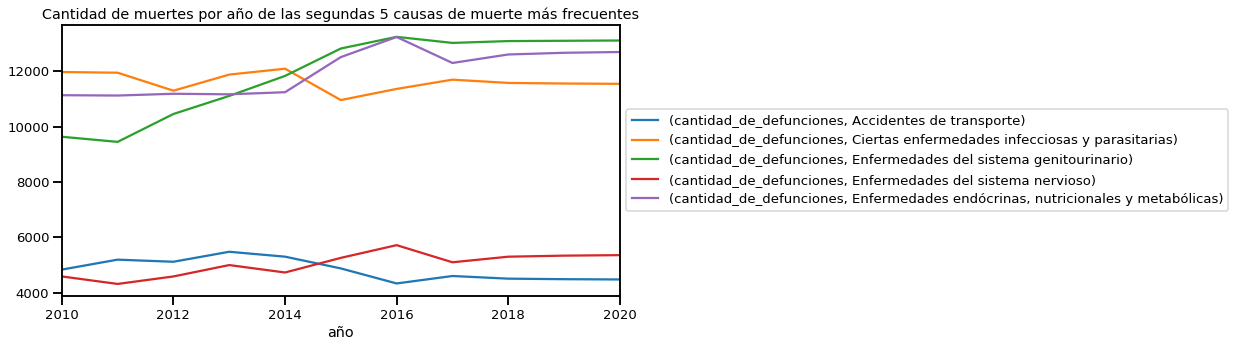

In [0]:
muertes_por_causa_año = defunciones_g.groupby(["causa_muerte"])["cantidad_de_defunciones"].sum().sort_values(ascending=False).iloc[5:15]
muertes_por_causa_año.to_frame()
df_muertes_por_causa_año = pd.DataFrame(muertes_por_causa_año)
df_muertes_por_causa_año['causa'] = df_muertes_por_causa_año.index
def2 = pd.DataFrame(defunciones_complete) 
def2 = def2.loc[(def2.causa_muerte == df_muertes_por_causa_año['causa'][0]) | (def2.causa_muerte == df_muertes_por_causa_año['causa'][1]) | (def2.causa_muerte == df_muertes_por_causa_año['causa'][2]) | (def2.causa_muerte == df_muertes_por_causa_año['causa'][3]) | (def2.causa_muerte == df_muertes_por_causa_año['causa'][4])]
flujo_tabla2 = pd.pivot_table(data = def2, values = ['cantidad_de_defunciones'], index = ['año'], columns = ['causa_muerte'], aggfunc= np.sum, )
sns.set_context("talk", font_scale=0.8)
flujo_tabla2.plot(title = "Cantidad de muertes por año de las segundas 5 causas de muerte más frecuentes", figsize=(10,5))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [0]:
flujo_tabla2

cantidad_de_defunciones  ...                                                     
causa_muerte Accidentes de transporte  ... Enfermedades endócrinas, nutricionales y metabólicas
año                                    ...                                                     
2010                             4830  ...                                              11133  
2011                             5189  ...                                              11121  
2012                             5113  ...                                              11185  
2013                             5474  ...                                              11165  
2014                             5297  ...                                              11241  
2015                             4872  ...                                              12510  
2016                             4329  ...                                              13237  
2017                             4598  ...                                              12298  
2018                             4502  ...                                              12605  
2019                             4483  ...                                              12666  
2020                             4473  ...                                              12694  

[11 rows x 5 columns]

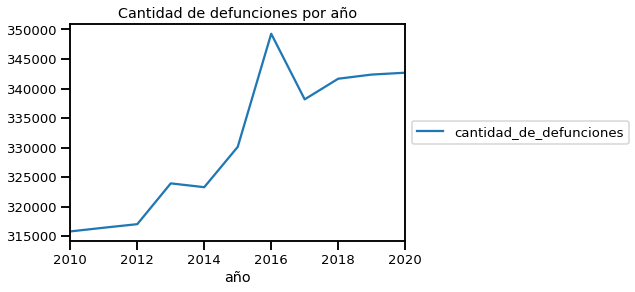

In [0]:
# Sumamos la cantidad de muertes por año
muertes_por_año = defunciones_complete.groupby(["año"])["cantidad_de_defunciones"].sum()
muertes_por_año.head(10)
sns.set_context("talk", font_scale=0.8)
muertes_por_año.plot(title = "Cantidad de defunciones por año")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

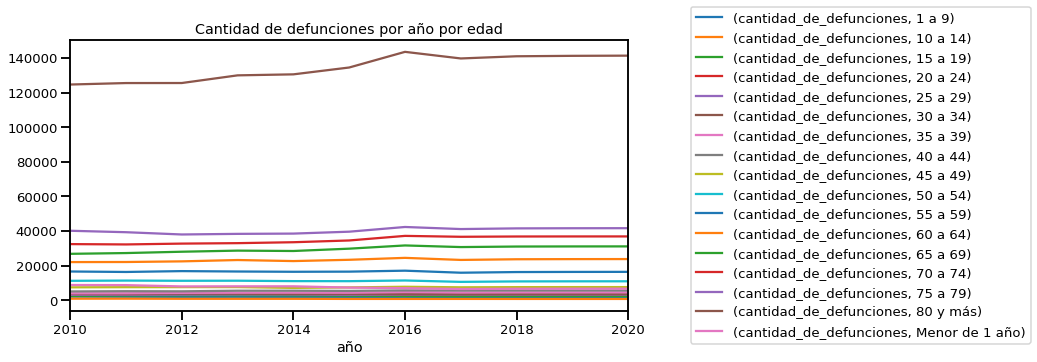

In [0]:
flujo_tabla2 = pd.pivot_table(data = defunciones_complete, values = ['cantidad_de_defunciones'], index = ['año'], columns = ['grupos_edad_nombre'], aggfunc= np.sum, )
sns.set_context("talk", font_scale=0.8)
flujo_tabla2.plot(title = "Cantidad de defunciones por año por edad", figsize=(10,5))
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.show()